<a href="https://colab.research.google.com/github/mrchapagain/SocialNetworkAnalytics/blob/main/TwiteerDataAnalytics-singleClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tweeter Data Analytics

***Here I will cover:***
1. *Tweets from twetter user*
2. *Tweets # search by keywords*

In [278]:
# Necessary libaries
from tweepy import OAuthHandler
from tweepy import API
import tweepy
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time


#Necessary information form tweet account
consumer_key='hYt37U1prLMj2LBfWaH3VfwAP'
consumer_secret='8sOKCBqlh0NLEByi3IjQ1mjlhTVhAtFzoOLqU9w5vn0qjmdAR1'
access_token='14970816-bxUWKHaeQvNpVP7nNzgOwWe2Sa3dsLAposBrhuhsg'
access_token_secret='nqioC9WEH7XFXpMU6KxmKuplZ4SIwmcgKAUzQYc1E2bXo'

#Tweepy authentication
auth = OAuthHandler(consumer_key, consumer_secret) # Consumer key authentication
auth.set_access_token(access_token, access_token_secret) # Access key authentication
api = API(auth)  # Set up the API with the authentication handler

##Obtaining Tweets from user ID
# Function to obtain tweet from specific user account
def tweets_by_user(user):
    limit=300
    tweets_obj= tweepy.Cursor(api.user_timeline, screen_name=user, count=200, tweet_mode="extended").items(limit)
            
    # Create Data Frame
    columns= ['Tweets', 'Likes', 'Time', 'User']
    tweets = []
    for i in tweets_obj:
      tweets.append([i.full_text, i.favorite_count, i.created_at, i.user.screen_name])

    df_by_id= pd.DataFrame(tweets, columns=columns)
    df_by_id['Time']=df_by_id['Time'].apply(lambda x: x.strftime('%Y-%m-%d'))

    #now lets make only tweets thats has not Re-Tweeted!
    df_by_id= df_by_id[~df_by_id.Tweets.str.contains("RT")]
            
    return df_by_id
            
            
# Obtaining tweet using keywords or Hastag
def tweets_by_keywords(keywords):
  limit=300
  tweets_obj= tweepy.Cursor(api.search, q=keywords, count=100, tweet_mode="extended").items(limit)
  # Create Data Frame
  columns= ['Tweets', 'Likes', 'Time', 'User']
  tweets = []
  for i in tweets_obj:
    tweets.append([i.full_text, i.favorite_count, i.created_at, i.user.screen_name])

  df_by_keywords= pd.DataFrame(tweets, columns=columns)
  df_by_keywords['Time']= df_by_keywords['Time'].apply(lambda x: x.strftime('%Y-%m-%d'))

  #now lets make only tweets thats has not Re-Tweeted!
  df_by_keywords= df_by_keywords[~df_by_keywords.Tweets.str.contains("RT")]
  return df_by_keywords     

In [290]:
# Analytics functions
import re
#from PIL import Image
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')
from nltk.stem.snowball import SnowballStemmer


def wordcloud_plot(df_col):
      # Create stopword list
      stopwords = set(STOPWORDS)
      stopwords.update(['https'])
      plt.figure()
      allWords= ' '.join( [twts for twts in df_col] )
      wordcloud = WordCloud(stopwords=stopwords, width= 1000, height=500, random_state=21, max_font_size= 119, background_color="skyblue").generate(allWords)
      plt.axis('off')
      plt.imshow(wordcloud, interpolation = "bilinear")
      #wordcloud.to_file("static/wordcloud_toshow.png")
      return wordcloud


def SentimentAnalysis(df):
      # first clean the text
      def cleanText(text):
            text= re.sub(r'@[A-Za-z0-9]+', '',text) # Removed @mentions
            text= re.sub(r'#', '',text) # the '#' symbol
            text= re.sub(r':', '',text) # the ':' symbol
            text= re.sub(r'RT[\s]+', '',text) # Removed RT
            text= re.sub(r'https?:\/\/\s+', '',text) # Removed the hyper link
            return text

      text= df['Tweets']
      #clean tweets
      df['Tweets']= df['Tweets'].apply(cleanText)

      #function to get the subjectivity
      def getSubjectivity(text=df['Tweets']):
            return TextBlob(text).sentiment.subjectivity
      #function to ge the polarity
      def getPolarity(text=df['Tweets']):
            return TextBlob(text).sentiment.polarity
      #Create to new columns
      df['Subjectivity']= df['Tweets'].apply(getSubjectivity)
      df['Polarity']= df['Tweets'].apply(getPolarity)

      # Function to sentiment
      def getAnalysis(score):
            if score < 0: return 'Negetive'
            elif score == 0: return 'Neutral'
            else: return 'Positive'
      # add Analytics column in the data frame
      df['Analysis']= df['Polarity'].apply(getAnalysis)
      #show the data
      df_withsentiment= df
      return df_withsentiment
    
#def export(self):return self.df

#Plot the sentiment dataframe
def sentiment_plot(df_withsentiment):
      rows=df_withsentiment.shape[0]
      plt.figure()
      plt.title(f'Sentiment Analysis of {rows} tweets')
      plt.xlabel('Sentiment of the tweets')
      plt.ylabel(f'Counts of sentiments')
      df_withsentiment['Analysis'].value_counts().plot(kind='bar')
      return plt

## Function to find most mentioned words with NLP
def most_mentioned_words(df_by_id):
      # Split all the sentances and creat the list of sentence of from the tweet columns
      list_of_sentences = [sentence for sentence in df_by_id.Tweets]

      lines = []
      for sentence in list_of_sentences:
            words = sentence.split()
            for w in words:
                  lines.append(w)

      # Removing Punctuation by using Regular Expression (RegEx)
      lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
      lines2= []
      for word in lines:
            if word != '':
                  lines2.append(word)
      
      # Stemming the words to their root
      s_stemmer = SnowballStemmer(language='english')
      stem= []
      for word in lines2:
            stem.append(s_stemmer.stem(word))

      # Removing all the stop words
      stem2= []
      for word in stem:
            if word not in nlp.Defaults.stop_words:
                  stem2.append(word)
      # Time to creat Dataframe 
      df2 = pd.DataFrame(stem2)
      df2 = df2[0].value_counts()
      
      # Lets visualize
      def vis(df2):
            df2= df2[:20,]
            plt.figure()
            sns.barplot(df2.values, df2.index, alpha=1)
            plt.title(f'Top words Overall from Tweet search')
            plt.ylabel('Word from Tweet')
            plt.xlabel('Count of Words')
      return vis(df2)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


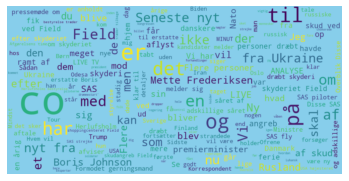

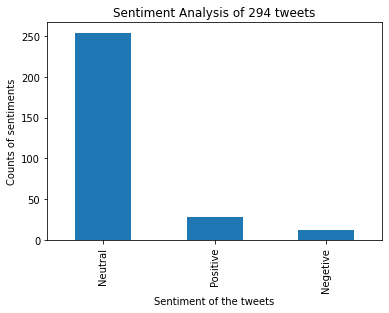

In [282]:
tweeter_id= "DRNyheder" #input("Type Tweter-id which is after @, fx DRNyheder for DR News: ") # fxDRNyheder
# lets use the function to ge the dataframe which gives fataframe with index
df_user_tweet= tweets_by_user(tweeter_id)

# Top 10 most liked tweets and lets rearrange columns and index
analyticss= df_user_tweet.loc[df_user_tweet.Likes.nlargest(10).index].reset_index(drop=True)[['Tweets', 'Likes', 'Time']]

#lets use word cloud function to get the wordcloud figure
wordclouds= wordcloud_plot(df_user_tweet.Tweets)

# use function to get dataframe with sentiment Analytic column
sentiments= SentimentAnalysis(df_user_tweet)[['Tweets', 'Likes', 'Time', 'Analysis']]

# Plot the Analytics columns of the sentiment dataframe 
sentimentsplot= sentiment_plot(sentiments)


#2.  Tweets search by using Keywords or Hashtag

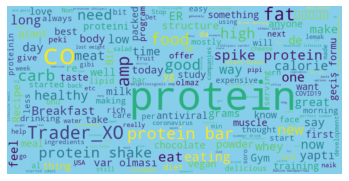

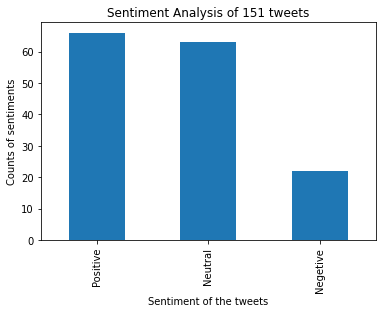

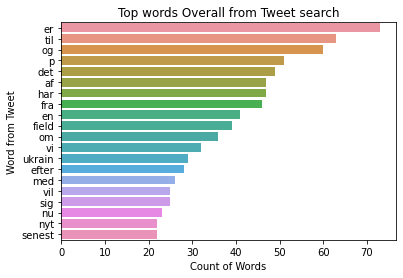

In [292]:
#Get the data by typing keywords and look Sentiment Analytics
keywords= "Protein" #input('Type the word you want to search tweet by: ')
df_by_keywords = tweets_by_keywords(keywords)

# Top 10 most liked tweets from keywords search and lets rearrange columns and index
analyticss= df_by_keywords.loc[df_by_keywords.Likes.nlargest(10).index].reset_index(drop=True)[['Time', 'Tweets', 'Likes', 'User']]

#lets use word cloud function to get the wordcloud figure
wordclouds= wordcloud_plot(df_by_keywords.Tweets)

# use function to get dataframe with sentiment Analytic column
sentiments= SentimentAnalysis(df_by_keywords)[['Tweets', 'Likes', 'Time', 'User', 'Analysis']]

# Plot the Analytics columns of the sentiment dataframe 
sentimentsplot= sentiment_plot(sentiments)

# Plot of the most mentioned text from Keyword search dataframe 
most_mentioned_words(df_user_tweet)

# Visualization with text processing

In [ ]:
# Visualization for mentions organizations
def show_ents(doc):
  if doc.ents:
    for ent in doc.ents:
      print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))

In [ ]:
str1 = " "
stem2 = str1.join(lines2)
stem2 = nlp(stem2)
label = [(X.text, X.label_) for X in stem2.ents]
df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])
df7 = df6.where(df6['Entity'] == 'ORG')
df7 = df7['Word'].value_counts()

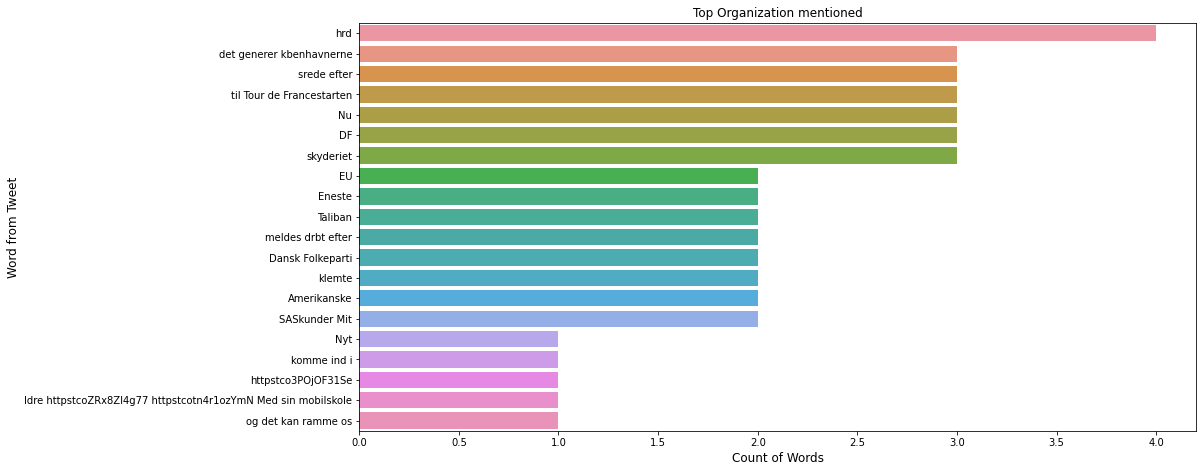

In [ ]:
# Visualization again
dfx= df7[:20, ]
plt.figure(figsize=(15,7.5))
sns.barplot(dfx.values, dfx.index, alpha=1)
plt.title('Top Organization mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [ ]:
str1 = " "
stem2 = str1.join(lines2)
stem2 = nlp(stem2)
label = [(X.text, X.label_) for X in stem2.ents]
df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])
df7 = df6.where(df6['Entity'] == 'PERSON')
df7 = df7['Word'].value_counts()

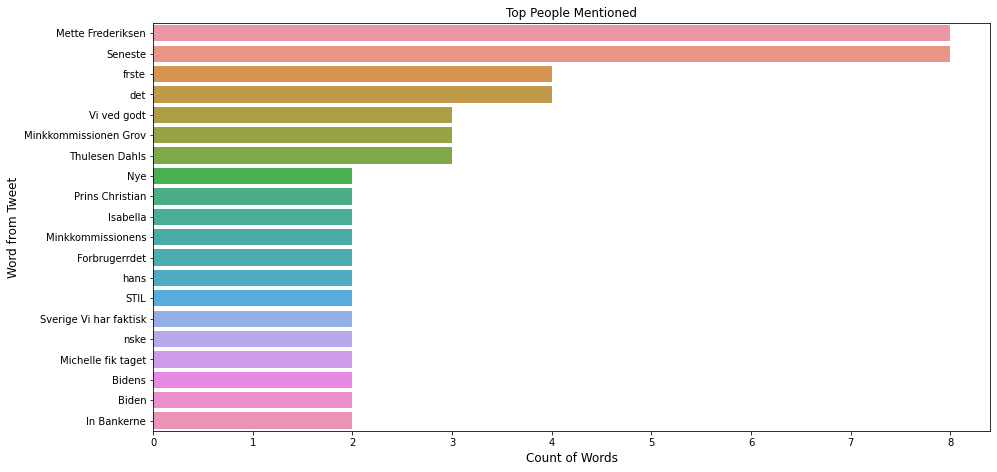

In [ ]:
# Visualization again
dfx= df7[:20, ]
plt.figure(figsize=(15,7.5))
sns.barplot(dfx.values, dfx.index, alpha=1)
plt.title('Top People Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()